# Kalman Higher Order Solver

$$
\newcommand{\var}{\operatorname{var}}
\newcommand{\cov}{\operatorname{cov}}
\newcommand{\N}{\mathcal N}
\newcommand{\vi}{v^\star}
$$

## Higher Order Solver

Let $y_t = (x^{(0)}_t, x^{(1)}_t, \ldots, x^{(q)}_t)$, such that the ODE is defined as

$$
a' y_t = F(y_t, t), \qquad y_0 = b,
$$

where $a_{q \times 1}$.  Note that this setup is somewhat flexible.  For instance you could use it to solve the ODE

$$
x^{(2)}_t + 2 x^{(1)}_t + \sin(x_t) + t = 0, \qquad x_0 = 2, \quad x^{(1)}_0 = 1.
$$

Then we could write

$$
a = (0, 1, 0), \quad F(y_t, t) = \frac{-x^{(2)}_t - \sin(x_t) - t}{2},
$$

or we could write

$$
a = (0, 2, 1), \quad F(y_t,t) = -\sin(x_t) - t.
$$

The solution prior is going to be on the CAR$(p)$ process $X_t = (x^{(0)}_t, \ldots, x^{(p-1)}_t)$ where $p > q$, such that the solution assumes at least $q$ continuous derivatives.

The algorithm goes like this:

1.  Let $X_0$ be compatible with $y_0 = c$.  I think a simple default is to assume that $X_0 \sim \N(0, V_{\infty})$, then condition on $y_0 = c$.  The first model interrogation is deterministic: $v_0^\star = F(y_0, 0)$ with variance $\Sigma_0^\star = 0$.
2.  Model interrogation:  Given that we have used the KF to store the mean and variance of $p(X_n \mid v_{0:n}^\star)$,
    - Do one forward step from Markov process $X_{n+1} \sim p(X_{n+1} \mid X_{0:n})$, via 
    
        $$
        X_n \sim p(X_n \mid v_{0:n}^\star), \qquad X_{n+1} \sim p(X_{n+1} \mid X_n).
        $$
        
    - Interrogate $v_{n+1}^\star = F(y_{n+1}, t_{n+1})$, and calculate $\Sigma_{n+1}^\star = \var(a'y_{n+1} \mid v_{0:n}^{\star})$.
3.  Forward-pass update $p(X_{n+1} \mid v_{0:n+1}^\star)$, where the observation model is

    $$
    v_{n+1}^\star \sim \N(a'y_{n+1}, \Sigma_{n+1}^\star),
    $$
        
    where $y_{n+1}$ are the first $p+1$ elements of $X_{n+1}$.
4.  Once you've done this for $N$ steps, backward-pass update (KF smoothing) to get $p(X_{0:N} \mid v_{0:N}^{\star})$. 

In [ ]:
import numpy as np
from math import exp, sqrt
import matplotlib.pyplot as plt
from BayesODE import var_car, cov_car
from BayesODE.Tests.root_gen import root_gen
from BayesODE.Tests.V_euler import V_euler
from BayesODE.utils import mvCond
from BayesODE._mou_car import _mou_car
from BayesODE.kalman_ode import filter_update_full

In [359]:
def kalman_initial_draw(roots, sigma, y0, p):
    
    """Computes the initial draw X0 for the kalman process X_0 ~ N(0, V_inf)`
    
    Parameters
    ----------
    
    roots: [p] :obj:`numpy.ndarray` of float
        Roots to the p-th order polynomial of the car(p) process (roots must be negative)
    sigma: float
        Parameter in mOU volatility matrix
    y0: [q] :obj:`numpy.ndarray` of float
        Initial conditions of the ode
    p: float
        Size of X0

    Returns
    -------
    
    X0: [p] :obj:`numpy.ndarray` of float
        Simulate X0 ~ N(0, V_inf) conditioned on y0.
    """
    q = len(y0) - 1
    X0 = np.zeros(p)    #Initialize p sized initial X0
    V_inf = cov_car([], roots, sigma, v_infinity=True)    #Get V_inf to draw X^{{q+1} ... (p-1)}_0
    icond = np.array([True]*(q+1) + [False]*(p-q-1))   #Conditioned on all but X^{{q+1} ... (p-1)}_0
    A, b, V = mvCond(np.zeros(p), V_inf, icond)    #Get mean and variance for p(z_0 | y_0 = c) where z_0 = X_0 \setminus y_0
    z_0 = np.random.multivariate_normal(A.dot(y0) + b, V)    #Draw X^{(p-1)}_0
    X0[:q+1] = y0    #Replace x^{(0), (1), (2) ... (q)}}_0 with y_0
    X0[q+1:] = z_0
    
    return X0

Given 
    $$
    X_{t+\Delta t} \mid X_t \sim \N(e^{-\Gamma \Delta t} X_t, V_{\Delta t}).
    $$
we can calculate $X_{n+1} \sim p(X_{n+1} \mid X_n)$ using `var_car` on $\Delta t = 1/N$.

So using the old variables we have:
    $$
    \begin{align*}
    A &= e^{-\Gamma \Delta t} \\
    V &= V_{\Delta t}
    \end{align*}
    $$

In [3]:
def higher_mvCond(delta_t, roots, sigma):
    
    """Calculate A, and V in X_{n+1} ~ p(X_{n+1} | X_n) using 
    .. :math: `A = e^{-\\Gamma \\Delta t}` and 
    .. :math: `V = V_{\\Delta t}`.
        
    Parameters
    ----------
    
    delta_t: [1] :obj:`numpy.ndarray` of float
        Step size between simulation points
    roots: [p] :obj:`numpy.ndarray` of float
        Roots to the p-th order polynomial of the car(p) process (roots must be negative)
    sigma: float
        Parameter in mOU volatility matrix

    Returns
    -------
    
    A: [p,p]  :obj:`numpy.ndarray` of float
        :math: `A = e^{-\\Gamma \\Delta t}`
    V: [p,p] :obj:`numpy.ndarray` of float
        :math: `V = V_{\\Delta t}`
    """

    delta = np.array(-roots)
    _, Q = _mou_car(roots, sigma)
    Q_inv = np.linalg.pinv(Q)
    V = var_car(delta_t, roots, sigma)[0]
    A = np.matmul(Q_inv.T * np.exp(-delta * delta_t[0]), Q.T)
    
    return A, V   

In [305]:
def kalman_ode_higher(fun, X0, N, A, V, a):
    from pykalman import standard as pks
    """Probabilistic ODE solver based on the Kalman filter and smoother.

    Returns an approximate solution to the higher order ODE

    .. math:: a' y_t = F(y_t, t)= f(y_t, t)
    
    where :math: y_t = (x^{(0)}_t, x^{(1)}_t, \\ldots, x^{(q)}_t) on the interval :math:`t \in [0, 1]`, with initial condition :math:`y_0 = y0`
    and :math: X_0 = (x^{(0)}_t, x^{(1)}_t, \\ldots, x^{(p)}_t) for p > q+1.
    Parameters
    ----------

    fun : function 
        Higher order ODE function :math: a' y_t = F(y_t, t) taking arguments `y` and `t`.
    X0 : float
        Initial value of :math:`x_t` at time :math:`t = 0`.
    N : int
        Number of discretization points of the time interval,
        such that discretization timestep is `dt = 1/N`.
    A : [p, p] 
        Transition matrix defining the solution prior (see below).
    V : [p, p] :obj:`numpy.ndarray`
        Variance matrix defining the solution prior. 
        
        .. math:: y_{n+1} = A y_n + V^{1/2} \epsilon_n, \qquad \epsilon_n \stackrel{iid}{\sim} \mathcal N(0, I_2).
    a : [p]
        Observation vector
    
    Returns
    -------

    Xn_mean : [N+1, p] :obj:`numpy.ndarray`
        Posterior mean of the solution process and its derivative :math:`y_n = (x_n, v_n)` at times :math:`t = 0,1/N,\ldots,1`.
    Xn_var : [N+1, p, p] :obj:`numpy.ndarray`
        Posterior variance of the solution process and its derivatives at times :math:`t = 0,1/N,\ldots,1`.
    """
    
    # notation consistent with pykalman package
    n_dim_obs = 1
    n_dim_state = len(X0)
    n_timesteps = N+1

    # allocate memory
    vs = np.zeros((n_timesteps,n_dim_obs)) 

    # var(vs_n | y_n), to be determined during the interrogation process
    sig2 = np.zeros((n_timesteps, n_dim_obs, n_dim_obs))

    # solution process
    # forward mean and variance.
    mu = np.zeros((n_timesteps, n_dim_state)) # E[y_n | vs_0:n]
    # var(y_n | vs_0:n)
    Sigma = np.zeros((n_timesteps, n_dim_state, n_dim_state))

    # arguments to use low-level pykalman functions
    observations = vs
    observation_matrix = a
    observation_offset = np.array([0.])
    observation_covariances = sig2 # multidimensional
    transition_matrix = np.array(A)
    transition_offset = np.zeros(n_dim_state)
    transition_covariance = np.array(V) # single dimensional
    filtered_state_means = mu
    filtered_state_covariances = Sigma
    predicted_state_means = np.zeros((n_timesteps, n_dim_state))
    predicted_state_covariances = np.zeros((n_timesteps, n_dim_state, n_dim_state))
    # initialize things
    mu[0] = X0
    vs[0] = X0.dot(a[0])
    predicted_state_means[0] = mu[0]
    predicted_state_covariances[0] = Sigma[0]

    # forward pass: merging pks._filter to accommodate multiple
    # observation_covariances
    # calculate mu_tt = E[y_t | vs_0:t-1] and
    # Sigma_tt = var(y_t | vs_0:t-1)

    for t in range(N):
        Xt = np.random.multivariate_normal(mu[t], Sigma[t]) # X_n ~ p(X_n | v_{0:n}*)
        X_tt = np.dot(A, Xt)
        Sigma_tt = np.linalg.multi_dot([A, Sigma[t], A.T]) + V #A*Sigma[n]*A.T + V 
        sig2[t+1] = np.linalg.multi_dot([a, Sigma_tt, a.T]) # new observation_covariance
        Xt1 = np.random.multivariate_normal(X_tt, Sigma_tt) #X_{n+1} ~ p(X_{n+1} | X_n)
        vs[t+1] = fun(Xt1,(t+1)/N) #new observation (v_{n+1})

        (predicted_state_means[t+1], predicted_state_covariances[t+1],
                 _, filtered_state_means[t+1],
                 filtered_state_covariances[t+1]) = (
                     filter_update_full(filtered_state_mean = filtered_state_means[t],
                                        filtered_state_covariance = filtered_state_covariances[t],
                                        observation = observations[t+1],
                                        transition_matrix = transition_matrix,
                                        transition_offset = transition_offset,
                                        transition_covariance = transition_covariance,
                                        observation_matrix = observation_matrix,
                                        observation_offset = observation_offset,
                                        observation_covariance = observation_covariances[t+1])
                 )
    # backward pass
    (smoothed_state_means, smoothed_state_covariances, _) = (
        pks._smooth(
            transition_matrix, filtered_state_means,
            filtered_state_covariances, predicted_state_means,
            predicted_state_covariances
        )
    )
    Xn_mean = smoothed_state_means
    Xn_var = smoothed_state_covariances
    return Xn_mean, Xn_var

## Tests

In [56]:
from math import sin
def F(y_t, t):
    return -2*y_t[1] - sin(y_t[0]) -t


In [57]:
N = 100
q = 2
p = q+2

delta_t = np.array([1/N])
r0 = np.random.uniform()
sigma = np.random.uniform()
roots = root_gen(r0, p) #Generate roots to draw x^{(3)}_0

a = np.array([[0,0,1,0]])
x0 = np.array([2,1,0])
y0 = np.array([2,1,F(x0, 0)]) #Initial state

X0 = kalman_initial_draw(roots, sigma, y0, p)
A, V = higher_mvCond(delta_t, roots, sigma) 

Xn_mean, Xn_var = kalman_ode_higher(F, X0, N, A, V, a)

## Example (6) in Chkrebtii Paper

As a simple example, consider the second order initial value ODE problem,

$$
\begin{align*}
u_{tt}(t) &= sin(2t) − u, \quad t ∈ [0, 10], \\
u_t(0) &= 0, \quad u(0) = −1. 
\end{align*}
$$


Its exact solution, $u^{\star}(t) = \frac{−3 cos(t) + 2 sin(t) − sin(2t)}{3}$

In [96]:
from math import sin, cos
def chk_F(y_t, t):
    return sin(2*t) - y_t[0] #X^{2} = sing(2t) - X

def chk_exact_x(t):
    return (-3*cos(t) + 2*sin(t) - sin(2*t))/3

def chk_exact_x1(t):
    return (-2*cos(2*t) + 3*sin(t) + 2*cos(t))/3

In [151]:
N = 100
q = 2
p = q+2

delta_t = np.array([1/N])
#r0 = np.random.uniform()
#sigma = np.random.uniform()
r0 = 0.3
sigma = 1
roots = root_gen(r0, p) #Generate roots to draw x^{(3)}_0
a = np.array([[0,0,1,0]])
x0 = np.array([-1,0,0])
y0 = np.array([-1,0,chk_F(x0, 0)]) #Initial state

X0 = kalman_initial_draw(roots, sigma, y0, p)
A, V = higher_mvCond(delta_t, roots, sigma) 

Xn_chk_mean, Xn_chk_var = kalman_ode_higher(chk_F, X0, N-1, A, V, a)

In [149]:
def kalman_tune(fun, r0p, sigmap, p, x0, y0, a, exact_sol_x):
    minerr = 1e10
    for r0 in r0p:
        for sigma in sigmap:
            roots = root_gen(r0, p) #Generate roots to draw x^{(3)}_0
            try:
                X0 = kalman_initial_draw(roots, sigma, y0, p)
                A, V = higher_mvCond(delta_t, roots, sigma) 
                kalman_x = kalman_ode_higher(fun, X0, N-1, A, V, a)[0][:,0]
                err = sum((exact_sol_x - kalman_x)**2)
                if err < minerr:
                    minerr = err
                    minr0 = r0
                    minsigma = sigma
            except:
                continue
    return minr0, minsigma


In [150]:
r0p = np.linspace(0.1, 1, 10)
sigmap = np.linspace(0.1,1,10)
kalman_tune(chk_F, r0p, sigmap, p, x0, y0, a, exact_chk_x)

(0.30000000000000004, 0.6)

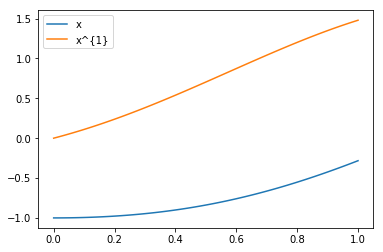

In [152]:
N = 100
tseq = np.linspace(0,1,N)
exact_chk_x = np.zeros(N)
exact_chk_x1 = np.zeros(N)
for t in range(N):
    exact_chk_x[t] = chk_exact_x(tseq[t])
    exact_chk_x1[t] = chk_exact_x1(tseq[t])
plt.plot(tseq,exact_chk_x,label='x')
plt.plot(tseq,exact_chk_x1,label='x^{1}')
plt.legend(loc='upper left')

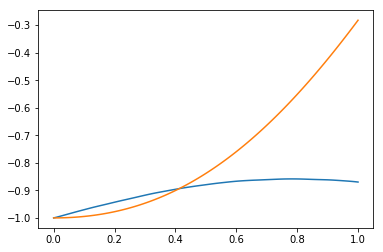

In [153]:
kalman_chk_x = Xn_chk_mean[:,0]
plt.plot(tseq,kalman_chk_x)
plt.plot(tseq,exact_chk_x)

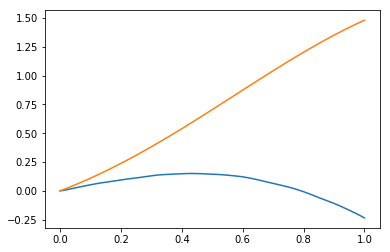

In [154]:
kalman_chk_x1 = Xn_chk_mean[:,1]
plt.plot(tseq,kalman_chk_x1)
plt.plot(tseq,exact_chk_x1)

## Textbook example 2 in 3.1

In [155]:
from math import exp

def text_F(y_t, t):
    return 4*y_t[0] + 12*t

def text_exact_x(t):
    return 3*exp(2*t) + exp(-2*t) -3*t

def text_exact_x1(t):
    return 6*exp(2*t)-2*exp(-2*t)-3


In [165]:
r0p = np.linspace(0.1, 10, 20)
sigmap = np.linspace(0.1,1, 20)
kalman_tune(text_F, r0p, sigmap, p, x0, y0, a, exact_text_x)

(0.6210526315789474, 0.6210526315789474)

In [177]:
N = 100
q = 2
p = q+2

delta_t = np.array([1/N])
#r0 = np.random.uniform()
#sigma = np.random.uniform()
r0 = 0.5
sigma = 0.62
roots = root_gen(r0, p) #Generate roots to draw x^{(3)}_0
a = np.array([[0,0,1,0]])
x0 = np.array([4,1,0])
y0 = np.array([4,1,text_F(x0, 0)]) #Initial state

X0 = kalman_initial_draw(roots, sigma, y0, p)
A, V = higher_mvCond(delta_t, roots, sigma) 

Xn_text_mean, Xn_text_var = kalman_ode_higher(text_F, X0, N-1, A, V, a)

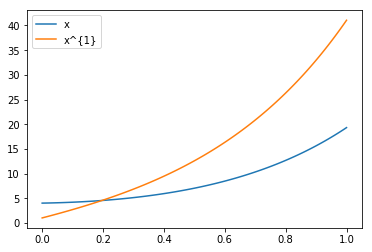

In [178]:
N = 100
tseq = np.linspace(0,1,N)
exact_text_x = np.zeros(N)
exact_text_x1 = np.zeros(N)
for t in range(N):
    exact_text_x[t] = text_exact_x(tseq[t])
    exact_text_x1[t] = text_exact_x1(tseq[t])
plt.plot(tseq,exact_text_x,label='x')
plt.plot(tseq,exact_text_x1,label='x^{1}')
plt.legend(loc='upper left')

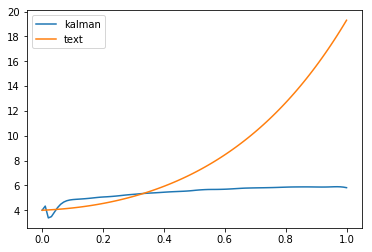

In [181]:
kalman_text_x = Xn_text_mean[:,0]
plt.plot(tseq,kalman_text_x, label= 'kalman')
plt.plot(tseq,exact_text_x, label = 'text')
plt.legend(loc='upper left')

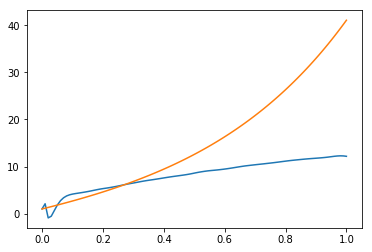

In [180]:
kalman_text_x1 = Xn_text_mean[:,1]
plt.plot(tseq,kalman_text_x1)
plt.plot(tseq,exact_text_x1)

## First Order ODE example

In [184]:
import BayesODE as bo

In [215]:
def first_F(y_t,t):
    return 3*(t+1/4) - y_t[0]/(t+1/4)

def f(y, t):
    return 3*(t+1/4) - y/(t+1/4)

In [341]:
t0 = 0
tn = 1
x0 = 0
N = 10
tseq = np.linspace(t0, tn, N)
gamma = 1.67
alpha = 1000

Sigma_vv = bo.cov_vv_ex(tseq, tseq, gamma, alpha)
Sigma_xx = bo.cov_xx_ex(tseq, tseq, gamma, alpha)
Sigma_xv = bo.cov_xv_ex(tseq, tseq, gamma, alpha)
x_bayes,_,_ = bo.bayes_ode(f, tseq, x0, Sigma_vv, Sigma_xx, Sigma_xv)

In [342]:
v_bayes = np.zeros(N)
for i in range(N):
    v_bayes[i] = f(x_bayes[i], tseq[i])
y_bayes = list(zip(x_bayes,v_bayes))

In [365]:
from BayesODE.Tests.test_exp_integrate import cov_yy_ex
gamma = 1.67
alpha = 1000
Sigma = cov_yy_ex(tseq[1:3], tseq[1:3], gamma, alpha)
icond = np.array([True]*2 + [False]*2)
mu = np.array([0, 0, 0, 0])
A, b, V = mvCond(mu, Sigma, icond)

In [366]:
N = 10
q = 1
p = q+1

delta_t = np.array([1/N])
r0 = np.random.uniform()
sigma = np.random.uniform()
roots = root_gen(r0, p) #Generate roots to draw x^{(3)}_0
a = np.array([[0,1]])
x0 = np.array([0,0])
y0 = np.array([0,first_F(x0,0)]) #Initial state

X0 = y0
#X0 = kalman_initial_draw(roots, sigma, y0, p)
#A, V = higher_mvCond(delta_t, roots, sigma) 

Xn_first_mean1, Xn_first_var1 = kalman_ode_higher(first_F, X0, N-1, A, V, a)

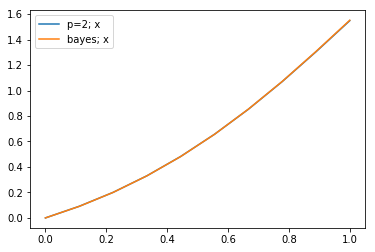

In [377]:
plt.plot(tseq,Xn_first_mean1[:,0], label='p=2; x')
plt.plot(tseq,x_bayes, label = 'bayes; x')
plt.legend(loc='upper left')

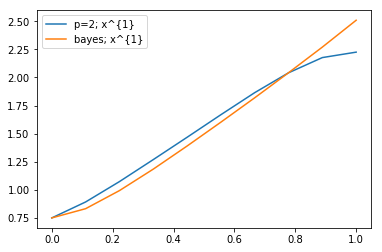

In [378]:
plt.plot(tseq,Xn_first_mean1[:,1], label='p=2; x^{1}')
plt.plot(tseq,v_bayes, label = 'bayes; x^{1}')
plt.legend(loc='upper left')

In [360]:
N = 10
q = 1
p = q+2
a = np.array([[0,1,0]])
r0p = np.linspace(0.1, 10, 20)
sigmap = np.linspace(0.1,1, 20)
kalman_tune(first_F, r0p, sigmap, p, x0, y0, a, x_bayes)

(1.142105263157895, 1.0)

In [355]:
N = 10
q = 1
p = q+2

delta_t = np.array([1/N])
#r0 = np.random.uniform()
#sigma = np.random.uniform()
r0 = 1.14

roots = root_gen(r0, p) #Generate roots to draw x^{(3)}_0
a = np.array([[0,1,0]])
x0 = np.array([0,0])
y0 = np.array([0,first_F(x0,0)]) #Initial state

X0, A, V = kalman_initial_draw(roots, sigma, y0, p)
A, V = higher_mvCond(delta_t, roots, sigma) 

Xn_first_mean2, Xn_first_var2 = kalman_ode_higher(first_F, X0, N-1, A, V, a)

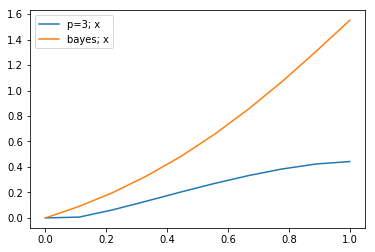

In [379]:
plt.plot(tseq,Xn_first_mean2[:,0], label='p=3; x')
plt.plot(tseq,x_bayes, label = 'bayes; x')
plt.legend(loc='upper left')

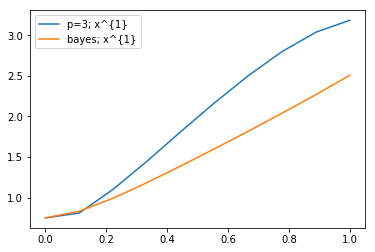

In [380]:
plt.plot(tseq,Xn_first_mean2[:,1], label='p=3; x^{1}')
plt.plot(tseq,v_bayes, label = 'bayes; x^{1}')
plt.legend(loc='upper left')